In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from mc_lab.metropolis_hastings import MetropolisHastingsSampler

In [6]:
class StereographicProjectionSampler1D:
    """
    Stereographic Projection Sampler for 1D distributions
    """

    def __init__(self, R=1.0, h=0.5):
        """
        Parameters:
        R: radius parameter for stereographic projection
        h: step size for random walk on sphere
        """
        self.R = R
        self.h = h
        self.R_sq = R * R  # Precompute R^2 for performance

    def SP_inverse(self, x):
        r"""
        Inverse stereographic projection: R^1 -> S^1 \ {North Pole}
        Maps from real line to circle
        """
        x_sq = x * x
        denom_inv = 1.0 / (x_sq + self.R_sq)

        z0 = 2 * self.R * x * denom_inv
        z1 = (x_sq - self.R_sq) * denom_inv

        return np.array([z0, z1])

    def SP(self, z):
        r"""
        Stereographic projection: S^1 \ {North Pole} -> R^1
        Maps from circle to real line
        """
        denom = 1 - z[1]
        if abs(denom) < 1e-10:
            return np.inf

        x = self.R * z[0] / denom
        return x

    def propose_on_sphere(self, z):
        """
        Propose new point on circle using tangent space random walk
        """
        # Sample random perturbation in R^2
        d_tilde_z0 = np.random.normal(0, self.h)
        d_tilde_z1 = np.random.normal(0, self.h)

        # Project to tangent space at z
        # z_norm_sq = z[0]**2 + z[1]**2, but for unit circle it's 1
        # Optimized: avoid dot product calculation
        z_dot_d = z[0] * d_tilde_z0 + z[1] * d_tilde_z1

        dz0 = d_tilde_z0 - z_dot_d * z[0]
        dz1 = d_tilde_z1 - z_dot_d * z[1]

        # Re-project to circle
        z_new0 = z[0] + dz0
        z_new1 = z[1] + dz1

        # Fast normalization
        norm_inv = 1.0 / np.sqrt(z_new0 * z_new0 + z_new1 * z_new1)
        z_new0 *= norm_inv
        z_new1 *= norm_inv

        return np.array([z_new0, z_new1])

    def step(self, x_current, log_density_func):
        """
        One step of the SPS algorithm for 1D
        """
        # Map current state to circle
        z = self.SP_inverse(x_current)

        # Propose new point on circle
        z_proposed = self.propose_on_sphere(z)

        # Map back to R^1
        x_proposed = self.SP(z_proposed)

        # Check for invalid proposals
        if np.isinf(x_proposed) or np.isnan(x_proposed):
            return x_current, False

        # Compute acceptance probability
        # For d=1: factor is (R^2 + x^2)
        x_current_sq = x_current * x_current
        x_proposed_sq = x_proposed * x_proposed

        log_ratio = (
            log_density_func(x_proposed)
            - log_density_func(x_current)
            + np.log(self.R_sq + x_proposed_sq)
            - np.log(self.R_sq + x_current_sq)
        )

        # Fast acceptance test
        if log_ratio >= 0:
            return x_proposed, True
        elif np.random.rand() < np.exp(log_ratio):
            return x_proposed, True
        else:
            return x_current, False

    def sample(self, x_init, log_density_func, n_samples, burn_in=1000):
        """
        Generate MCMC samples using SPS
        """
        samples = np.zeros(n_samples)
        x_current = float(x_init)
        n_accepted = 0

        # Burn-in
        for _ in range(burn_in):
            x_current, _ = self.step(x_current, log_density_func)

        # Sampling
        for i in range(n_samples):
            x_current, accepted = self.step(x_current, log_density_func)
            samples[i] = x_current
            if accepted:
                n_accepted += 1

        accept_rate = n_accepted / n_samples

        return samples, accept_rate


In [7]:
class BimodalDistribution:
    """
    Bimodal distribution: mixture of two Gaussians
    p(x) = w * N(x; mu1, sigma1^2) + (1-w) * N(x; mu2, sigma2^2)
    """

    def __init__(self, mu1=-3, sigma1=1, mu2=3, sigma2=1, weight=0.5):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.weight = weight

    def density(self, x):
        """Compute density at x"""
        comp1 = self.weight * norm.pdf(x, self.mu1, self.sigma1)
        comp2 = (1 - self.weight) * norm.pdf(x, self.mu2, self.sigma2)
        return comp1 + comp2

    def log_density(self, x):
        """Compute log density at x"""
        dens = self.density(x)
        if dens <= 0:
            return -np.inf
        return np.log(dens)


Running SPS sampler...
Running RWM sampler (small step)...
Running RWM sampler (large step)...


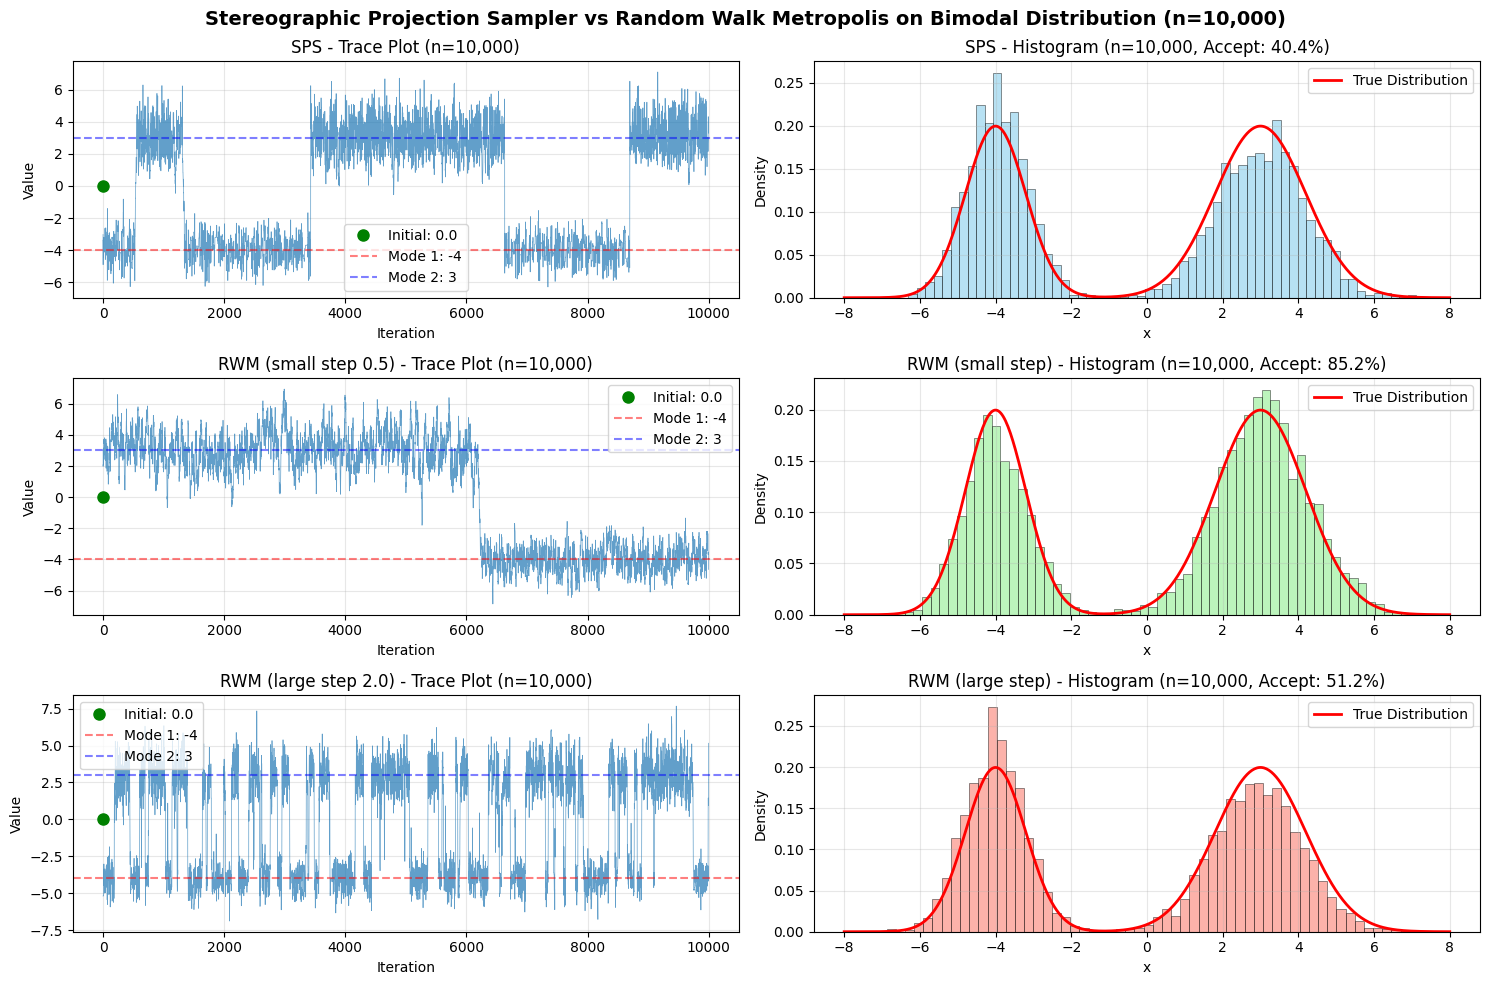

In [8]:
def compare_samplers_bimodal():
    """
    Compare SPS with standard Random Walk Metropolis on bimodal distribution
    """
    np.random.seed(42)

    # Create bimodal distribution
    bimodal = BimodalDistribution(mu1=-4, sigma1=0.8, mu2=3, sigma2=1.2, weight=0.4)

    # Random Walk Metropolis using MetropolisHastingsSampler
    def rwm_sample_with_mh(
        x_init, log_density_func, n_samples, step_size=0.5, burn_in=1000
    ):
        """Wrapper to use MetropolisHastingsSampler with specified parameters"""
        sampler = MetropolisHastingsSampler(
            log_target=log_density_func,
            proposal_scale=step_size,
            var_names=["x"],
            adaptive_scaling=False,  # Disable adaptation to match custom behavior
        )

        # Sample using the MH sampler
        idata = sampler.sample(
            n_samples=n_samples,
            n_chains=1,
            burn_in=burn_in,
            initial_states=np.array([x_init]),
            progressbar=False,
        )

        # Extract samples and acceptance rate
        samples = idata.posterior["x"].values[0]  # Get samples from chain 0
        acceptance_rates = sampler.get_acceptance_rates(idata)
        accept_rate = acceptance_rates["overall"]

        return samples, accept_rate

    # Run both samplers
    n_samples = 10000
    x_init = 0.0  # Start between modes

    # SPS
    print("Running SPS sampler...")
    sps_sampler = StereographicProjectionSampler1D(R=1.5, h=0.6)
    sps_samples, sps_accept = sps_sampler.sample(
        x_init, bimodal.log_density, n_samples, burn_in=1000
    )

    small_step_size = 0.5
    # RWM with different step sizes
    print("Running RWM sampler (small step)...")
    rwm_samples_small, rwm_accept_small = rwm_sample_with_mh(
        x_init, bimodal.log_density, n_samples, step_size=small_step_size, burn_in=1000
    )

    large_step_size = 2.0
    print("Running RWM sampler (large step)...")
    rwm_samples_large, rwm_accept_large = rwm_sample_with_mh(
        x_init, bimodal.log_density, n_samples, step_size=large_step_size, burn_in=1000
    )

    # Create figure with subplots
    plt.figure(figsize=(15, 10))

    # True distribution
    x_range = np.linspace(-8, 8, 500)
    true_density = [bimodal.density(x) for x in x_range]

    # Trace plots
    trace_length = 10000  # Show first 2000 samples

    # SPS trace plot
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(sps_samples[:trace_length], alpha=0.7, linewidth=0.5)
    ax1.plot(0, x_init, "go", markersize=8, label=f"Initial: {x_init}", zorder=5)
    ax1.axhline(
        y=bimodal.mu1,
        color="red",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 1: {bimodal.mu1}",
    )
    ax1.axhline(
        y=bimodal.mu2,
        color="blue",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 2: {bimodal.mu2}",
    )
    ax1.set_title(f"SPS - Trace Plot (n={n_samples:,})")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Value")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # SPS histogram
    ax2 = plt.subplot(3, 2, 2)
    ax2.hist(
        sps_samples,
        bins=60,
        density=True,
        alpha=0.6,
        color="skyblue",
        edgecolor="black",
        linewidth=0.5,
    )
    ax2.plot(x_range, true_density, "r-", linewidth=2, label="True Distribution")
    ax2.set_title(f"SPS - Histogram (n={n_samples:,}, Accept: {sps_accept:.1%})")
    ax2.set_xlabel("x")
    ax2.set_ylabel("Density")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # RWM (small step) trace plot
    ax3 = plt.subplot(3, 2, 3)
    ax3.plot(rwm_samples_small[:trace_length], alpha=0.7, linewidth=0.5)
    ax3.plot(0, x_init, "go", markersize=8, label=f"Initial: {x_init}", zorder=5)
    ax3.axhline(
        y=bimodal.mu1,
        color="red",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 1: {bimodal.mu1}",
    )
    ax3.axhline(
        y=bimodal.mu2,
        color="blue",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 2: {bimodal.mu2}",
    )
    ax3.set_title(f"RWM (small step {small_step_size}) - Trace Plot (n={n_samples:,})")
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Value")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # RWM (small step) histogram
    ax4 = plt.subplot(3, 2, 4)
    ax4.hist(
        rwm_samples_small,
        bins=60,
        density=True,
        alpha=0.6,
        color="lightgreen",
        edgecolor="black",
        linewidth=0.5,
    )
    ax4.plot(x_range, true_density, "r-", linewidth=2, label="True Distribution")
    ax4.set_title(
        f"RWM (small step) - Histogram (n={n_samples:,}, Accept: {rwm_accept_small:.1%})"
    )
    ax4.set_xlabel("x")
    ax4.set_ylabel("Density")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # RWM (large step) trace plot
    ax5 = plt.subplot(3, 2, 5)
    ax5.plot(rwm_samples_large[:trace_length], alpha=0.7, linewidth=0.5)
    ax5.plot(0, x_init, "go", markersize=8, label=f"Initial: {x_init}", zorder=5)
    ax5.axhline(
        y=bimodal.mu1,
        color="red",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 1: {bimodal.mu1}",
    )
    ax5.axhline(
        y=bimodal.mu2,
        color="blue",
        linestyle="--",
        alpha=0.5,
        label=f"Mode 2: {bimodal.mu2}",
    )
    ax5.set_title(f"RWM (large step {large_step_size}) - Trace Plot (n={n_samples:,})")
    ax5.set_xlabel("Iteration")
    ax5.set_ylabel("Value")
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # RWM (large step) histogram
    ax6 = plt.subplot(3, 2, 6)
    ax6.hist(
        rwm_samples_large,
        bins=60,
        density=True,
        alpha=0.6,
        color="salmon",
        edgecolor="black",
        linewidth=0.5,
    )
    ax6.plot(x_range, true_density, "r-", linewidth=2, label="True Distribution")
    ax6.set_title(
        f"RWM (large step) - Histogram (n={n_samples:,}, Accept: {rwm_accept_large:.1%})"
    )
    ax6.set_xlabel("x")
    ax6.set_ylabel("Density")
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.suptitle(
        f"Stereographic Projection Sampler vs Random Walk Metropolis on Bimodal Distribution (n={n_samples:,})",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.savefig("sps_vs_rwm_bimodal.pdf", dpi=600, bbox_inches="tight")
    plt.show()

    return sps_samples, rwm_samples_small, rwm_samples_large


if __name__ == "__main__":
    sps_samples, rwm_samples_small, rwm_samples_large = compare_samplers_bimodal()
